In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats, linalg
import torch
import fastai
import re

In [106]:
train_data = pd.read_csv("C:/worksspace/purr-price-prediction/train.csv")
test_data = pd.read_csv("C:/worksspace/purr-price-prediction/test.csv")

# approach: (1) use only images to predict (2) image combined with tabular data, for this purpose we will use the library image_tabular
# what is cool down time? 

In [107]:
train_data

,id,price,speed,image
0,7d46fd31038904e2,2.13,Fast (1m),./images/7d46fd31038904e2.png
1,76690b9129b9895c,0.46,Catatonic (1w),./images/76690b9129b9895c.png
2,c5f9966acce22205,10,Swift (2m),./images/c5f9966acce22205.png
3,dfcbc3748fa8e4ba,2,Catatonic (1w),./images/dfcbc3748fa8e4ba.png
4,eefb9c589f2ad43a,1,Snappy (10m),./images/eefb9c589f2ad43a.png
...,...,...,...,...
1995,307a15aebca02b38,5.08,Fast (1m),./images/307a15aebca02b38.png
1996,9c85020f7a7bdf6b,0.3,Swift (2m),./images/9c85020f7a7bdf6b.png
1997,b02b3492e6b7cd6b,1.44,Fast (1m),./images/b02b3492e6b7cd6b.png
1998,21dd1ee9b54261af,2.5,Fast (1m),./images/21dd1ee9b54261af.png


In [108]:
train_data.dtypes

id       object
price    object
speed    object
image    object
dtype: object

In [109]:
# firstly, we want to checkout how the speed influences the price (correlation, genral trend)

train_data[train_data["price"].str.contains(",")]

,id,price,speed,image
169,f3d35c91c9326e2f,"1,000,000",Fast (1m),./images/f3d35c91c9326e2f.png
492,d8f329f21806993d,"19,999.995",Swift (2m),./images/d8f329f21806993d.png
1750,8710ef3010f0f6bc,"10,000",Fast (1m),./images/8710ef3010f0f6bc.png
1938,ef35cc81fb7967c3,"15,000",Fast (1m),./images/ef35cc81fb7967c3.png


In [110]:
train_data["price"] = train_data["price"].apply(lambda x : x.replace(",","") if "," in x else x)

In [111]:
train_data[train_data["price"].str.contains(",")]

,id,price,speed,image


In [112]:
train_data["price"] = train_data[("price")].astype(float)

In [113]:
train_data["speed"].unique()

array(['Fast (1m)', 'Catatonic (1w)', 'Swift (2m)', 'Snappy (10m)',
       'Swift (5m)', 'Snappy (30m)', 'Brisk (1h)', 'Slow (16h)',
       'Plodding (4h)', 'Plodding (8h)', 'Brisk (2h)', 'Sluggish (4d)',
       'Sluggish (2d)', 'Slow (24h)'], dtype=object)

In [114]:
# re.search(r"\(([A-Za-z0-9]+)\)", 'Snappy (10m)').group(1)
def get_time(s):
    res_str = re.search(r"\(([A-Za-z0-9]+)\)", s).group(1)
    res = parse_time_string(res_str)
    return res

# we want to convert all time strings to numbers (unit is minute)
def parse_time_string(s):
    items = re.match(r"([0-9]+)([a-z]+)", s, re.I).groups()
    num = int(items[0])
    unit = items[1]
    if "m" in unit:
        return num
    elif "h" in unit:
        return 60 * num
    elif "d" in unit:
        return 60 * 24 * num
    else: # "w"
        return 60 * 24 * 7 * num

In [115]:
stuff = re.match(r"([0-9]+)([a-z]+)", "10m", re.I).groups()
"m" in stuff[1]

True

In [116]:
train_data["speed"] = train_data["speed"].apply(lambda x: get_time(x))

In [117]:
train_data["id"]

0       7d46fd31038904e2
1       76690b9129b9895c
2       c5f9966acce22205
3       dfcbc3748fa8e4ba
4       eefb9c589f2ad43a
              ...       
1995    307a15aebca02b38
1996    9c85020f7a7bdf6b
1997    b02b3492e6b7cd6b
1998    21dd1ee9b54261af
1999    cf63e5026eb6d155
Name: id, Length: 2000, dtype: object

In [118]:
train_data.dtypes

id        object
price    float64
speed      int64
image     object
dtype: object

<AxesSubplot:xlabel='speed', ylabel='Count'>

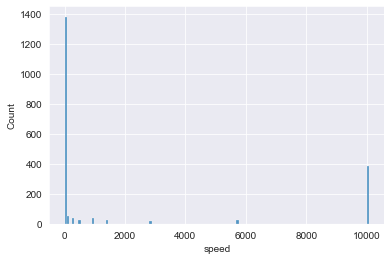

In [119]:
sns.histplot(data=train_data, x="speed")
# when plotting count or density, be careful with continuous data

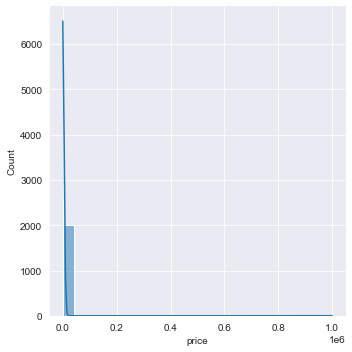

In [120]:
sns.displot(x=train_data["price"], bins=25, kde=True)

<AxesSubplot:xlabel='price'>

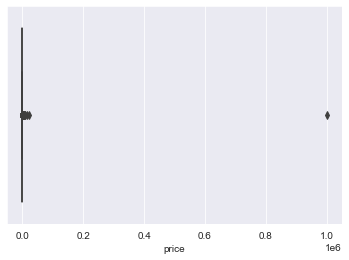

In [121]:
sns.boxplot(x=train_data["price"])

In [122]:
# back up the original data
train_data_original = train_data

In [147]:
train_data_original

,id,price,speed,image
0,7d46fd31038904e2,2.13,1,./images/7d46fd31038904e2.png
1,76690b9129b9895c,0.46,10080,./images/76690b9129b9895c.png
2,c5f9966acce22205,10.00,2,./images/c5f9966acce22205.png
3,dfcbc3748fa8e4ba,2.00,10080,./images/dfcbc3748fa8e4ba.png
4,eefb9c589f2ad43a,1.00,10,./images/eefb9c589f2ad43a.png
...,...,...,...,...
1995,307a15aebca02b38,5.08,1,./images/307a15aebca02b38.png
1996,9c85020f7a7bdf6b,0.30,2,./images/9c85020f7a7bdf6b.png
1997,b02b3492e6b7cd6b,1.44,1,./images/b02b3492e6b7cd6b.png
1998,21dd1ee9b54261af,2.50,1,./images/21dd1ee9b54261af.png


In [150]:
train_data = train_data_original.drop(train_data_original[train_data_original["price"] > 20].index)

In [151]:
train_data

,id,price,speed,image
0,7d46fd31038904e2,2.13,1,./images/7d46fd31038904e2.png
1,76690b9129b9895c,0.46,10080,./images/76690b9129b9895c.png
2,c5f9966acce22205,10.00,2,./images/c5f9966acce22205.png
3,dfcbc3748fa8e4ba,2.00,10080,./images/dfcbc3748fa8e4ba.png
4,eefb9c589f2ad43a,1.00,10,./images/eefb9c589f2ad43a.png
...,...,...,...,...
1994,36048d3c9d0cd992,9.90,1,./images/36048d3c9d0cd992.png
1995,307a15aebca02b38,5.08,1,./images/307a15aebca02b38.png
1996,9c85020f7a7bdf6b,0.30,2,./images/9c85020f7a7bdf6b.png
1997,b02b3492e6b7cd6b,1.44,1,./images/b02b3492e6b7cd6b.png


<AxesSubplot:xlabel='price'>

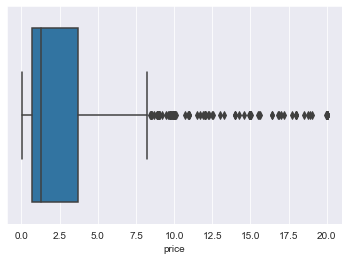

In [152]:
sns.boxplot(x=train_data["price"])

<AxesSubplot:xlabel='speed', ylabel='price'>

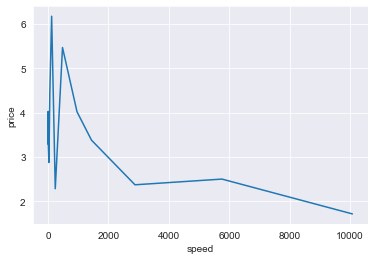

In [153]:
# the relation between speed and price
sns.lineplot(data=train_data, x="speed", y="price", errorbar=None)
# it seems that generally very long cooling time corresponds to lower prices

<AxesSubplot:>

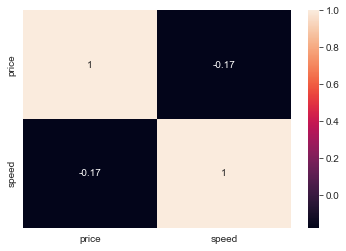

In [154]:
# the correlation matrix ssuggests the same kind of weak correlation
sns.heatmap(train_data.corr(), annot=True)